Michael Downs (mdowns@g.harvard.edu) is interested in continuing this project into the next semester. 

# AM 207 Project: Stein Variational Gradient Descent

**Final Deliverable**

**Done by:** Michael Downs, Andrew Chia

Original Paper:
https://arxiv.org/pdf/1608.04471.pdf

Our implementation is available at:
https://github.com/michaeldowns2/am207_project_code

The author's implementation is available at:
https://github.com/DartML/Stein-Variational-Gradient-Descent


In [1]:
%matplotlib inline
import random
import time

from jax import grad, vmap, jit
import jax.numpy as jnp
import jax.scipy as jsp
import jax.scipy.stats as jsps

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy as sp
import scipy.spatial as spsp


from scipy.stats import multivariate_normal


# Set seed for reproducibility
random.seed(207)
np.random.seed(207)

# Table of Contents

* [Background and Context](#Background-and-Context)
* [Problem Statement](#Problem-Statement)
* [Technical Content (High Level)](#Technical-Content-(High-Level))
* [Existing Work](#Existing-Work)
* [Novel Contribution](#Novel-Contribution)
* [Technical Content (Details)](#Technical-Content-(Details))
    * [Stein's Identity](#Stein's-Identity)
    * [Kernelized Stein Discrepancy](#Kernelized-Stein-Discrepancy)
    * [Directional Derivative of KL Divergence](#Directional-Derivative-of-KL-Divergence)
    * [Steepest Descent in RKHS](#Steepest-Descent-in-RKHS)
    * [Stein Variational Gradient Descent Algorithm](#Stein-Variational-Gradient-Descent-Algorithm)
* [Author's Experiments](#Author's-Experiments)   
* [Code for Project and Our Experiments](#Code-for-Project-and-Our-Experiments)
    * [Gaussian Mixture Model (GMM) Module](#Gaussian-Mixture-Model-(GMM)-Module)
    * [Hamiltonian Monte Carlo (HMC) Module](#Hamiltonian-Monte-Carlo-(HMC)-Module)
    * [Our implementation of SVGD](#Our-implementation-of-SVGD)
    * [Pedagogical Example (1D Gaussian Mixture)](#Pedagogical-Example-(1D-Gaussian-Mixture))
    * [More Complicated Case (2D Gaussian Mixture)](#More-Complicated-Case-(2D-Gaussian-Mixture))
    * [Failure Modes](#Failure-Modes)
        * [Mode seeking (KL divergence)](#Mode-seeking-(KL-divergence))
        * [Too many particles](#Too-many-particles)
        * [Suboptimal RBF parameter](#Suboptimal-RBF-parameter)
        * [Insufficient # of iterations](#Insufficient-#-of-iterations)
        * [Suboptimal learning rate](#Suboptimal-learning-rate)     
        * [Numerical Instability under high correlation](#Numerical-Instability-under-high-correlation)
* [Evaluation](#Evaluation)
* [Future work](#Future-work)        

## Background and Context


A common problem in modern machine learning is producing accurate samples from complicated, high dimensional distributions with nontrivial correlation structures.

For example, sampling is a fundamental problem in Bayesian modelling. Indeed, in Bayesian statistics, model parameters $\mathbf{\theta}$ follow a probability distribution and inference is performed by sampling from the posterior distribution $p(\theta|D_X)$ of these parameters given a dataset $D_X$. Contrasted with frequentist inference, this interpretation of the model parameters as having their own distributions rather than being fixed gives rise to natural and attractive uncertainty characterizations over both the parameters and the model's predictions. Such characterizations are important in domains where mispredictions are costly as they give an indication that the model is not sure of its prediction and human experts should be involved. Thus, there are many reasons why practicioners might prefer the often more complicated Bayesian paradigm. 

For many problems of practical interest, however, especially in a high dimensional setting sampling techniques such as the MCMC family may fail to converge, making Bayesian inference challenging. Models such as Bayesian Neural Networks can have tens of thousands of parameters and, though they have the potential to be quite expressive, achieving convergence when sampling from a BNN posterior through MCMC techniques takes substantial effort.

An alternative approach to directly sampling from the distribution of interest is to instead reduce the sampling problem to an optimization problem by finding a simple distribution for which sampling is trivial that optimally approximates the intractible posterior under some divergence measure. The most common divergence measure is the KL-divergence, which gives a non-symmetric measure of the discrepancy between two probability distributions. This family of techniques is called variational inference and is not without its own drawbacks.

There is a tradeoff between the expressiveness of the approximating distribution and the ease of the minimization problem. The "search space" for the approximating distribution is known as the variational family. Typically, one will assume that the variational family is a set of distributions that have the same parametric form. More complicated variational families may better approximate the posterior, but minimizing the KL divergence may be more difficult. Another drawback of naive variational inference is that it has difficulty capturing the correlation structure of an arbitrary distribution because explicitly modelling the correlation in the variational family leads to an intractible optimization problem, epecially in the very high dimensional setting. Practitioners often use the mean field assumption that the variational family factors completely into a product of independent distributions (i.e. each random variable is independent, an often unrealistic assumption). Thus, variational inference tends to be a very artisanal process with many design choices.

## Problem Statement

In their Stein Variational Gradient Descent (SVGD) (2016) paper, Liu and Wang propose a novel sampling algorithm that solves the problem of obtaining accurate samples from an arbitrary distribution as long as the gradient of the logarithm of its density (GLD) is known. SVGD was intended to be an improvement over current variational inference techniques and the framework of variational inference provides the primary motivation for their work, but their derived approach can be used as a general sampling algorithm. Accurate and robust sampling algorithms make possible the use of complicated, high-dimensional Bayesian models and along with them their powerful uncertainty characterizations. Because machine learning models are being used more often in domains such as medicine, law, criminal justice, and consumer finance, where uncertainty characterizations are important, obtaining samples reliably and accurately can have societal impact.

Another problem Liu and Wang sought to solve was that of making variational inference less of an artisanal process thereby making it more broadly usable by non-experts. Indeed, their proposed algorithm ends up having quite a simple form and does not require specfying a parametric variational family. Lowering the barrier to entry of variational inference, a powerful class of techniques, could accelerate the pace of scientific research in other areas and also reduce the effort required in many engineering tasks.

## Technical Content (High Level) 

One approach to optimizing functions of multiple variables is using gradient information. Techniques that use gradient information are known as first order methods and an example of a first-order method is gradient descent, where iterative steps along the direction of the negative of the gradient (the direction of steepest descent) are taken until the iterations arrive at a local minima.

In variational inference, the optimization problem is that of minimizing a functional, the KL divergence over a variational family q for a fixed target distribution p. Functionals are maps from a space of functions to the real numbers, and such optimization problems are generally harder, though choosing a parametric variational family reduces the functional optimization to an ordinary multivariate optimization problem. The authors propose a procedure that is analogous to gradient descent, except over a space of functions, and the variational family is non-parametric.

The authors of SVGD connect a recent mathematical result which gives a closed form solution for a particular functional optimization problem with the directional derivative of the KL divergence and derive an iterative transformation that is analagous to taking steps along the direction of steepest descent in function space. A sketch of their derivation is below:

* set the variational family to be the set of distributions obtained by smooth transforms, which can approximate smooth distribution arbitrarily closely
* consider the distribution $q_{[T]}$ obtained by a small perturbation of the identity transform $T(\mathbf{x}) = \mathbf{x} + \epsilon \boldsymbol{\phi}(\mathbf{x})$ where $\mathbf{x}$ comes from some simple distribution (usually the prior) and $\boldsymbol{\phi}(\mathbf{x})$ is some function which is analagous to a direction
* define the directional derivative of the KL divergence of p from $q_{[T]}$ for a particular choice of $\boldsymbol{\phi}(\mathbf{x})$ and determine its form: $\nabla_{\epsilon} KL(q_{[T]} || p) |_{\epsilon=0} = -\mathbb{E}[\text{trace}(\mathcal{A}_p\boldsymbol{\phi}(\mathbf{x}))]$ (where $\mathcal{A}_p$ is the Stein operator which is defined in [Technical Content (Details)](#Technical-Content-(Details))) and:
* cast optimizing the directional derivative as a functional optimization problem in $\boldsymbol{\phi}(\mathbf{x})$ (i.e. the authors derive the above identity and then note that they can choose a $\boldsymbol{\phi}(\mathbf{x})$ that makes the change in the KL as large as possible which makes $\boldsymbol{\phi}(\mathbf{x})$ analagous to a direction of steepest descent for the KL in function space)
* restrict the set of $\boldsymbol{\phi}(\mathbf{x})$ in order to make the optimization problem tractable 
* leverage the closed form solution of the functional optimization problem to find the optimal perturbation "direction" to iteratively transform an arbitrary initial distribution $q_0$ into $q_n$ which approximates $p$ as closely as possible within the variational family
* continue applying the above procedure until the perturbation function is the zero function.

Theoretically, the above procedure proposes a way to obtain a density that approximates the posterior. Practically speaking, though, the authors use particles (samples from a distribution) to represent the current $q$ in the steepest descent iterations. In other words, the above result motivates an algorithm for iteratively transforming a set of particles sampled from an arbitrary distribution to mimicking samples from the target distribution. The transforms are iteratively applied on a set of samples from an arbitrary initial distribution, and the terms in the updates they derive in the paper are approximated by this set of samples at each update. See the section "[Technical Content (Details)](#Technical-Content-(Details))" for a more detailed derivation and the derived particle updates.

## Existing Work

The most similar prior work is "[Variational Inference with Normalizing Flows](https://arxiv.org/abs/1505.05770)"  which also tackles the problem of removing the choice of variational family. The approach proposed in that paper, however, requires additional design considerations over SVGD. Both approaches involve iterative transforms of a density, but the SVGD transforms are automatically determined (given a kernel) whereas the normalizing flow transformations must be specified. "[An introduction to sampling via measure transport](https://arxiv.org/abs/1602.05023)"  extends the technique of normalizing flows by ensuring that the transforms have certain necessary properties. 

"[The Variational Gaussian Process](https://arxiv.org/abs/1511.06499)"  also proposes a variational family which is a universal approximator, but involves matrix inversion. Other works such as  
* [Doubly Stochastic Variational Bayes for non-Conjugate Inference](http://proceedings.mlr.press/v32/titsias14.pdf)
* [Affine Independent Variational Inference](https://papers.nips.cc/paper/4512-affine-independent-variational-inference.pdf)
* [Variational Gaussian Copula Inference](https://arxiv.org/abs/1506.05860)
* [Copula variational inference](https://arxiv.org/abs/1506.03159)

also propose variable transforms for variational inference.

SVGD works by iteratively transforming a set of particles to become samples from a given density. Other works based on transforming particles include:

* [Approximating Posterior Distributions in Belief Networks using Mixtures](https://pdfs.semanticscholar.org/6101/44e669c2a5ee8c8bd13fef019e6514a82dad.pdf)
* [Improving the Mean Field Approximation Via the Use of Mixture Distributions](https://link.springer.com/chapter/10.1007/978-94-011-5014-9_6)
* [Variational Inference in Probabilistic Models](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.67.2348&rep=rep1&type=pdf)
* [Variational Particle Approximations](http://www.jmlr.org/papers/volume18/15-615/15-615.pdf)
* [Nonparametric Variational Inference](http://gershmanlab.webfactional.com/pubs/GershmanHoffmanBlei12.pdf)
* [Monte Carlo Statistical Methods](https://www.webpages.uidaho.edu/~stevel/565/R/R%20-%20George%20Casella/MCSMshortcourse09.pdf)
* [Sequential Monte Carlo Methods in Practice](https://link.springer.com/book/10.1007/978-1-4757-3437-9)
* [Provable Bayesian Inference via Particle Mirror Descent](https://arxiv.org/abs/1506.03101)

## Novel Contribution

There already exist many sampling algorithms. SVGD's contribution is that it is fairly powerful and able to obtain high dimensional samples, but has an algorithmically simple form that does not require many matrix operations such as matrix inversions or determinants.

Broadly speaking, SVGD attempts to make variational inference easier by introducing a non-parametric variational family that is a universal approximator of smooth densities (removing the requirement of choosing a variational family) and showing how to obtain samples from the best approximating distribution in this variational family.


## Technical Content (Details)

### Stein's Identity

Stein's Identity is a result from probability theory that relates the gradient of the logarithm of the density (GLD) for an arbitrary distribution to a smooth transformation and the transformation's gradient.

Let $p(\mathbf{x})$ be a smooth density with support $\mathcal{X} \in \mathbb{R}^d$. Let $\boldsymbol{\phi}(\mathbf{x})$ be a smooth transform on $\mathcal{X}$ i.e. 

\begin{equation*}
\boldsymbol{\phi}(\mathbf{x}) = \begin{bmatrix}
\phi_1(\mathbf{x}) \\
\phi_2(\mathbf{x}) \\ 
\vdots \\
\phi_d(\mathbf{x}) \\ 
\end{bmatrix} \\
\end{equation*}

We say that $\boldsymbol{\phi}(\mathbf{x})$ is in the Stein Class of p if either

1. $\mathcal{X}$ is compact and $p(\mathbf{x})\phi_i(\mathbf{x}) = 0$ $\forall i, \forall \mathbf{x} \in \partial \mathcal{X}$ (where $\partial \mathcal{X}$ means on the boundary of $\mathcal{X})$ or 
2. $\lim_{\|x\| \to \infty} p(\mathbf{x}) \phi_i(\mathbf{x}) = 0$ $\forall i$ when $\mathcal{X} = \mathbb{R}^d$.

We are largely concerned with the latter case in this project. Define the Stein operator $\mathcal{A}_p$ to be:

\begin{equation*}
\mathcal{A}_p \boldsymbol{\phi}(\mathbf{x}) = \boldsymbol{\phi}(\mathbf{x}) \nabla_{\mathbf{x}} \log p(\mathbf{x})^T  + \nabla_{\mathbf{x}} \boldsymbol{\phi}(\mathbf{x})\\
\end{equation*}


If $\boldsymbol{\phi}(\mathbf{x})$ is in the Stein Class of p, then Stein's Identity states that:

\begin{equation}
\mathbb{E}_{\mathbf{x} \sim p} \left[\mathcal{A}_p \boldsymbol{\phi}(\mathbf{x}) \right] = \mathbf{0}
\end{equation}


This can be verified using the [multivariate integration by parts](https://en.wikipedia.org/wiki/Integration_by_parts#Higher_dimensions).



### Kernelized Stein Discrepancy

Let $k(\mathbf{x}, \mathbf{x}'): \mathcal{X} \times \mathcal{X} \to \mathbb{R}$ be a positive definite kernel (any matrix induced by some set of $\mathbf{x}$ is positive definite).

Let $\mathcal{H}$ be its Reproducing Kernel Hilbert Space (RKHS). Let $\mathcal{H}^d$ be a space of vector functions $\mathbf{f}$ where

\begin{equation*}
\mathbf{f} = \begin{bmatrix}
f_1 \\
f_2 \\ 
\vdots \\
f_d \\ 
\end{bmatrix} \\
\end{equation*}

and each $f_i \in \mathcal{H}$. These spaces have an inner product, which we will not define here. Reference the original paper for the inner product.

For a given function set $\mathcal{F}$, one can use Stein's Identity to define a discrepancy measure between two probability distributions. Let $q$ be some other density supported on $\mathcal{X}$. Then the Stein discrepancy of p from q induced by $\mathcal{F}$ is

\begin{equation}
\mathbb{S}(q, p) = \underset{\boldsymbol{\phi} \in \mathcal{F}}{\max} \{[\mathbb{E}_{\mathbf{x} \sim q} \text{trace} (\mathcal{A}_p \boldsymbol{\phi}(\mathbf{x})) ]^2\}
\end{equation}

and can be interpreted as "the maximum violation of Stein's Identity". In general, this functional optimization problem is intractible and one has to choose a reduced $\mathcal{F}$. If one chooses $\mathcal{F}$ to be the subset of $\mathcal{H}^d$ such that $\|\boldsymbol{\phi}\| \le 1$, then the discrepancy is referred to as a Kernelized Stein Discrepancy and has a closed-form solution. Let 

\begin{equation}
\boldsymbol{\phi}_{q,p}^{*} (\mathbf{x}') = \mathbb{E}_{\mathbf{x} \sim q} \left[\mathcal{A}_p k(\mathbf{x}, \mathbf{x}') \right]\\ 
\end{equation}

Then the function that maximizes the Kernelized Stein Discrepancy is $\frac{\boldsymbol{\phi}_{q,p}^{*} (\mathbf{x}')}{\|\boldsymbol{\phi}_{q,p}^{*} (\mathbf{x}')\|}$


In this paper, the kernel is chosen to be the RBF kernel for its nice properties (it is always in the Stein Class of p).


### Directional Derivative of KL Divergence

Let $\mathbf{f}$ be a vector valued function. Its directional derivative in the direction $\mathbf{u}$ is:

\begin{equation}
\frac{d}{d\alpha}_{\alpha=0} \mathbf{f}(\mathbf{x + \alpha\mathbf{u}})
\end{equation}

Now consider the KL divergence of p from q:

\begin{equation}
KL(q || p)
\end{equation}

Let $\boldsymbol{\phi} \in \mathcal{H}^d$ with $\|\boldsymbol{\phi}\| = 1$. Let $q$ be a simple distribution. Let $\mathbf{T} (\mathbf{x}) = \mathbf{x} +  \epsilon \boldsymbol{\phi}(\mathbf{x})$.  Let $q_{[\mathbf{T}]}$ be the distribution obtained by transforming the support of q with $\mathbf{T}$. It can be shown that (see the paper for the proof) the directional derivative of the KL divergence is:

\begin{equation}
\frac{d}{d\epsilon} KL(q_{[\mathbf{T}]} || p)|_{\epsilon = 0} = - \mathbb{E}_{x \sim q}[\text{trace}(\mathcal{A}_{p} \boldsymbol{\phi}( \mathbf{x}))] \\
\end{equation}



### Steepest Descent in RKHS

Using the closed form solution from [Kernelized Stein Discrepancy](#Kernelized-Stein-Discrepancy) we have that the direction of steepest descent for transforming $q$ is

\begin{align*}
\boldsymbol{\phi}_{q,p}^{*} (\mathbf{x}') &= \mathbb{E}_{\mathbf{x} \sim q} \left[\mathcal{A}_p k(\mathbf{x}, \mathbf{x}') \right]\\ 
&= \mathbb{E}_{\mathbf{x} \sim q} \left[ k(\mathbf{x}, \mathbf{x}') \nabla_{\mathbf{x}} \log p(\mathbf{x}) + \nabla_{\mathbf{x}} k(\mathbf{x}, \mathbf{x}') \right]\\ 
\end{align*}.

This gives us an iterative procedure for transforming an arbitrary starting distribution $q$ into $p$.

Note that this procedure is implicitly performing variational inference where the variational family is the set of distributions obtained by smooth transforms of a tractable reference distribution. This set is able to approximate a smooth distribution arbitrarily closely.

### Stein Variational Gradient Descent Algorithm

In practice, the above transform is performed on a set of particles (samples from the starting distribution q).

The SVGD algorithm is then:

<img src="./figs/svgd.png">

Because SVGD depends only on p through its gradient, the normalizing constant is not necessary and the algorithm is broadly applicable.

The term on the left can be interpreted as driving the particles toward regions of high density for p and the term on the left prevents the particles from collapsing onto eachother.

When using the RBF kernel, the bandwith parameter h is taken to be $\frac{\text{med}^2}{\log n}$ where med is the median of the pairwise distances of the current set of particles and n is the number of particles. This heuristic is chosen so that $\sum_{j}k(x_i, x_j) \approx 1$ so that the contributions in the sum above are roughly balanced between all the points.

In practice, when using SVGD in Bayesian inference, one can initialize the particles using the prior distribution. 

One can also modify the particle updates using the stochastic gradient descent modifications such as momentum, adagrad, and adam.

## Author's Experiments

The authors performed three experiments on an increasingly difficult set of sampling tasks:

* A 1D Gaussian Mixture where the modes are close
* a Bayesian Logistic Regression
* A Bayesian Neural Network

These experiments were trying to show that SVGD indeed produces accurate samples from even complicated distributions and that SVGD is competitive with existing approaches not only in terms of producing accurate samples but also speed. The samples obtained via SVGD are used to compute various metrics that are intended to give a sense of whether they are actually coming from the target distribution.

<img src="./figs/toy.png">


For the 1D Gaussian Mixture, the modes are at -2 and 2 and are weighted unequally (1/3, 2/3). The particles are initialized near -10 and the authors show that the particles eventually make it to where the modes are located and also recover the mode that's farther away. They visually verify that the kernel density estimate (KDE) of the SVGD particles morphs into the target density. They repeat SVGD several times and use the final set of particles to compute various expectations, showing that the computed expectations either match or outperform regular Monte Carlo expectations. These two visual and numeric checks would suggest that SVGD is accurately producing samples from the 1D GMM. The authors did not, however explore what happens when the modes are moved farther apart, which we do in our failure modes analysis. We discovered that the particles exhibit mode seeking behavior and that, while SVGD appears to produce accurate samples in this case, the authors gave a false impression of robustness.

The authors then assess how well SVGD works for a binary classification task using Bayesian Logistic Regression on simple datasets and a more complicated one. On the simple datasets, the authors compare SVGD with a no-U-turn sampler (NUTS) and non-parametric variational inference. On the more complicated ones, the authors compare SVGD with stochastic gradient Langevin dynamics, particle mirror descent, and doubly stochastic variational inference. They are hoping to show that SVGD produces posterior weights that are able to achieve a similar or superior level of performance as when using these other techniques. Their results suggest that SVGD is competitive on both the simple and more complicated dataset. On the simple datasets, the accuracy obtained from SVGD is comparable with the NUTS and non-parametric variational inference. They then demonstrate that the logistic regression weights obtained from SVGD yield superior accuracy on the more complicated dataset compared with the other approaches. The fact that the samples obtained via SVGD performed no worse in terms of classification accuracy than the other samplers is promising. It is possible that the authors did not compare against the best possible samplers, but we would not have the domain expertise to know that.

Finally, the authors perform a similar set of experiments for a more complicated model by comparing SVGD with probabilisitc backpropagation (PBP) to obtain samples from the posterior of a Bayesian Neural Network. They also find that the weights obtained by SVGD yield metrics that are on par with PBP, which suggests that the samples from SVGD are from the posterior.

On the surface, the results of these experiments are promising and vindicate the author's claims.

## Code for Project and Our Experiments

### Gaussian Mixture Model (GMM) Module

To support our experiments, we wrote a small GMM module which contains functions for computing the density, log density, log likelihood, and gradient log density (GLD) for an arbitrary GMM as well as sampling functionality. We leverage JAX (https://github.com/google/jax), the successor to autograd for computing the gradient of an arbitrary GMM.

In [2]:
def mvn_pdf(x, mu, sigma):
    k = len(mu)
    

    term1 = (2*jnp.pi)**(-k/2)
    term2 = 1./jnp.sqrt(jnp.linalg.det(sigma))
    term3 = jnp.exp(-1./2 * (x - mu).T @ jnp.linalg.inv(sigma) @ (x - mu))

    return term1 * term2 * term3


def mvn_pdf_vectorized(x, mu, sigma):
    """
    assumes x is a num_samples x num_dimensions array.
    performs the density computations in a vectorized manner
    """
    k = len(mu)

    demeaned_x = x - mu

    first_prod = jnp.linalg.inv(sigma) @ demeaned_x.T

    second_prod = demeaned_x * first_prod.T

    reduction = np.sum(second_prod, axis=1).flatten()

    term1 = (2*jnp.pi)**(-k/2)
    term2 = 1./jnp.sqrt(jnp.linalg.det(sigma))
    term3 = jnp.exp(-1./2 * reduction)

    return term1 * term2 * term3 

"""
For the below functions:
weights: the weight on each mode. Sum cannot exceed 1
mus: list of means
sigmas: list of covariance matrices
* weights, mus and sigmas must have same length
"""
# Outputs function for the gmm PDF
def gmm_pdf(weights, mus, sigmas):
    def p(x):

        pdfval = 0

        for weight, mu, sigma in zip(weights, mus, sigmas):
            pdfval = pdfval + weight * mvn_pdf(x, mu, sigma)

        return pdfval

    return p

# Vectorized version of gmm pdf
def gmm_pdf_vectorized(weights, mus, sigmas):
    def p(x):

        pdfval = 0

        for weight, mu, sigma in zip(weights, mus, sigmas):
            pdfval = pdfval + weight * mvn_pdf_vectorized(x, mu, sigma)

        return pdfval

    return p

# Finite differences function to check the analytic GLD
def finite_diff(g, h, weights, mus, sigmas):
    def f(x):
        return (g(x + h, weights, mus, sigmas) - g(x, weights, mus, sigmas))/h

    return f

# Outputs function for log of the PDF
def log_gmm_pdf(weights, mus, sigmas):
    p = gmm_pdf(weights, mus, sigmas)

    def logp(x):
        return jnp.log(p(x))

    return logp

# Vectorized version of log gmm pdf
def log_gmm_pdf_vectorized(weights, mus, sigmas):
    p = gmm_pdf_vectorized(weights, mus, sigmas)

    def logp(x):
        return jnp.log(p(x))

    return logp

# Outputs log likelihood of gmm
def log_lik_gmm(weights, mus, sigmas ):

    p = gmm_pdf_vectorized(weights, mus, sigmas)

    def log_lik(x):
        return jnp.sum(jnp.log(p(x)))

    return log_lik

# Produces analytic gradient log density for gmm
def gmm_gld(weights, mus, sigmas):

    logp = log_gmm_pdf(weights, mus, sigmas)

    return jit(vmap(grad(logp)))

# Produces samples from gmm
def sample_gmm(num_samples, weights, mus, sigmas):

    num_pdfs = len(weights)

    result = []
    for i in range(num_samples):
        # choose distribution
        idx = np.random.choice(range(num_pdfs), p=weights)

        mu = mus[idx]
        sigma = sigmas[idx]

        # sample from distribution
        sample = np.random.multivariate_normal(mu, sigma)

        result.append(sample)

    return np.array(result)

### Hamiltonian Monte Carlo (HMC) Module

As a basis for comparison, we modified the HMC we implemented from homework 7 and used it to generate samples for the two cases (1D and 2D Gaussian mixture) we explore later.

In [3]:
def hmc_sampler(**kwargs):
    """ Samples from a target distribution converted to energy function u_energy
    Uses Euclidean-Gaussian Kinetic Energy and Leap-frog integrator
    """
    ## Setup
    t0 = time.time()
    #read in all arguments
    u_energy = kwargs['u_energy']
    step_size = kwargs['step_size']
    leapfrog_steps = kwargs['leapfrog_steps']
    total_samples = kwargs['total_samples']
    burn_in = kwargs['burn_in']
    thinning_factor = kwargs['thinning_factor']
    m = kwargs['m']
    #init a vector to hold the samples
    samples = []
    #start with specified initial position
    q_curr = kwargs['position_init']
    #define the dimension of p
    d = len(q_curr.flatten())
    #define the gradient of U
    ugrad = kwargs['u_grad']
    
    ## Params for kinetic energy
    #define mean
    mu = np.repeat(0, d)
    #define variance
    sig = np.identity(d) * m
    
    #set current u_energy
    ue_curr = u_energy(q_curr)
    
    #keep track of acceptance probability
    ap = 0
    
    # Repeat total_samples times
    for sam in range(total_samples):
        if sam % 100 == 0:
            print(f'At iteration {sam}')
        ## Step A: kick-off
        #sample random momentum
        p_curr = np.random.multivariate_normal(mu, sig)
    
        ## Step B: simulate movement
        #repeat for leapfrog_steps-1 times
        p_step = np.copy(p_curr)
        q_step = np.copy(q_curr)
        for step in range(leapfrog_steps):
            #half-step update for momentum
            p_step = p_step - step_size/2*ugrad(q_step)
            #full-step update for potential
            q_step = q_step + step_size/m*p_step
            #half-step update for momentum
            p_step = p_step - step_size/2*ugrad(q_step)
            
        ## Step C: Reverse momentum
        p_step = -p_step
        
        ## Step D: Correction for simulation error
        #compute total energy at current and step
        h_curr = ue_curr + 0.5 / m * np.linalg.norm(p_curr) ** 2
        h_step = u_energy(q_step) + 0.5 / m * np.linalg.norm(p_step) ** 2
        #generate alpha
        alpha = min(1, (np.exp(h_curr - h_step)))
        #sample from uniform
        u = np.random.uniform()
        #MH step
        if u <= alpha:
            #accept
            q_curr = q_step
            ue_curr = u_energy(q_curr)
            ap += 1
        #append whatever is current
        samples.extend(q_curr)
    
    #convert samples to numpy array
    samples = np.asarray(samples)
    #print acceptance rate
    print(f'The acceptance rate is {ap/total_samples:0.3f}')
    # Burning and thinning
    t1 = time.time()
    print(f'HMC Sampler took {t1-t0} seconds.')
    return samples[round(burn_in*len(samples))::thinning_factor, :]

### Our implementation of SVGD

We implemented SVGD in NumPy and used vectorized operations where possible. We took an objected oriented approach and our API consists of an SVGD class that takes as input the gradient of the logarithm of the density for some distribution and exposes a method "do_svgd_iterations_optimized" which takes as input the initial particles and the SVGD parameters such as the number of iterations and the learning rate. 

We leverage SciPy routines such as spsp.distance.pdist, which we use to compute the pairwise distances for the kernel matrix and rbf parameter. 

Our implementation currently only supports the RBF kernel and all kernel computations are currently hard-coded. 

Our NumPy code uses broadcasting to assemble the third order tensors which contain all of the computations for each of the two terms in the SVGD updates. That is, we simultaneously compute all kernel values, kernel derivatives, and GLDs for all particles, reduce the third dimension via np.mean, and update all of the particles at once.

All code for our implementation is available at https://github.com/michaeldowns2/am207_project_code.

In [4]:
class SVGD:
    def __init__(self, gld=None):
               
        if gld is None:
            raise ValueError("GLD not defined")

        self.gld = gld

    @staticmethod
    def rbf_param_function(X, dists):
        """
        X: Current data
        """

        return np.median(dists)**2 / np.log(len(X))

    @staticmethod
    def compute_rbf_kernel_matrix(particles, dists, h, num_particles):
        sq_dists = dists**2

        kernel_vals = np.exp(-1./h * sq_dists)

        K = np.zeros((num_particles, num_particles))

        K[np.triu_indices(num_particles, 1)] = kernel_vals

        K = K + K.T
        np.fill_diagonal(K, 1)

        return K

    @staticmethod
    def compute_rbf_kernel_deriv(particles, h, K_reshaped):
        broadcasted_subtraction = particles[:, np.newaxis] - particles

        broadcasted_subtraction = np.rot90(broadcasted_subtraction, axes=(2, 1))
        broadcasted_subtraction = np.rot90(broadcasted_subtraction, axes=(0, 2))

        broadcasted_multiplication = K_reshaped * broadcasted_subtraction

        partials_matrix = 2 * -1./h * broadcasted_multiplication

        return partials_matrix



    def do_svgd_iterations_optimized(self, init_particles,
                           num_iterations=1000,
                                     learning_rate=0.01,
                                     plotfunc=None,
                                     metrics=None,
                                     alpha=0.9,
                                     progress_freq=10):
        """
        Core implementation of SVGD
        """

        # eps is to prevent division by zero for adagrad updates
        eps = 1e-6
        historical_updates = 0

        num_particles, dim = init_particles.shape
        current_particles = init_particles

        img_num = 0
        for l in range(num_iterations):
            if l == 0:
                if plotfunc is not None:
                    plotfunc(-1, current_particles)
            
            dists = spsp.distance.pdist(current_particles)


            # get new kernel param
            h = SVGD.rbf_param_function(current_particles, dists)


            # get gradient values in a vectorized fashion
            gld = np.array(self.gld(current_particles))

            # rotate gld 90 degrees counterclockwise about axis
            # normal to yz plane
            gld_reshaped = gld.reshape(num_particles, dim, 1)
            gld_reshaped = np.rot90(gld_reshaped, axes=(0, 2))

            # get kernel matrix
            K = SVGD.compute_rbf_kernel_matrix(current_particles, dists,
                                               h, num_particles)

            # rotate K 90 degrees counterclockwise about axis
            # normal to xy
            K_reshaped = K.reshape(num_particles, num_particles, 1)
            K_reshaped = np.rot90(K_reshaped, axes=(1, 2))


            # compute broadcasted product representing first term in SVGD updates
            term1 = K_reshaped * gld_reshaped

            term1 = term1.mean(axis=2)

            # get kernel matrix gradient
            dK = SVGD.compute_rbf_kernel_deriv(current_particles, h, K_reshaped)
            term2 = dK.mean(axis=2)


            updates = term1 + term2

            # do adagrad with momentum as per the author's implementation

            if l == 0:
                historical_updates = updates ** 2
            else:
                historical_updates = alpha * historical_updates + (1 - alpha) * (updates ** 2)

            adj_updates = np.divide(updates, eps + np.sqrt(historical_updates))

            current_particles = current_particles + (learning_rate) * adj_updates


            if l % round(num_iterations / progress_freq) == 0:
                print("Iteration {}, {}% finished".format(l, round(l/num_iterations * 100, 2)))

                if plotfunc is not None:
                    plotfunc(l, current_particles)

                if metrics is not None:
                    metrics(current_particles)



        return current_particles


   


### Pedagogical Example (1D Gaussian Mixture)

To both showcase our implementation and provide a simple pedagogical example, we reproduce the author's results on their toy example, which is a 1D Gaussian mixture. The problem here is sampling from a chosen distribution. Our target distribution is:

$$ p(x) \sim \frac{1}{3}\mathcal{N}(-2, 1) + \frac{2}{3}\mathcal{N}(2, 1) $$

As per the paper, we approximate this distribution using $n = 100$ particles initialized near -10. To assess the performance of our implementation, we visually compare the kernel density estimate (KDE) of the particles that our implementation produces against the KDE of a sample drawn from the target distribution). We use the KDEs as a quick visual check and comparing the KDE of the final SVGD particle with the KDE from the true samples is a more fair comparison.

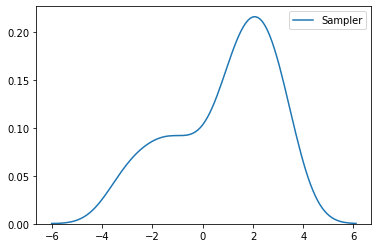

In [5]:
# We first visualize the KDE of the target distribution

num_samples = 100

weights = [1./3, 2./3]
mus = [np.array([-2]),
           np.array([2])]

sigmas = [np.eye(1),
              np.eye(1)]

true_samples = sample_gmm(num_samples, weights, mus, sigmas)


fig, ax = plt.subplots(1,1)

kde1 = sns.kdeplot(true_samples.flatten(), ax=ax, label='Sampler')


ax.legend()
plt.show()
plt.close()

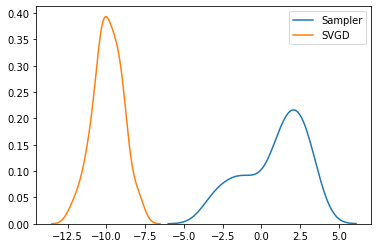

/Users/michaeldowns/miniconda3/envs/am207_project/lib/python3.7/site-packages/jax/lib/xla_bridge.py:120: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')
/Users/michaeldowns/miniconda3/envs/am207_project/lib/python3.7/site-packages/jax/lax/lax.py:4599: UserWarning: Explicitly requested dtype float64 requested in eye is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


Iteration 0, 0.0% finished


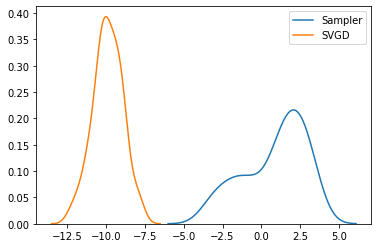

Iteration 500, 10.0% finished


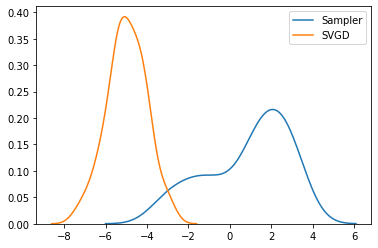

Iteration 1000, 20.0% finished


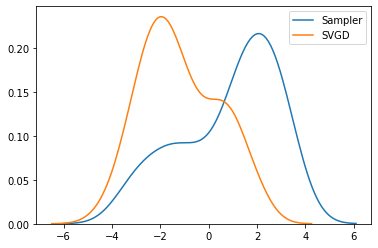

Iteration 1500, 30.0% finished


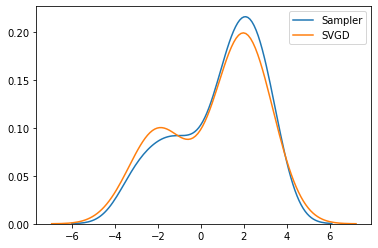

Iteration 2000, 40.0% finished


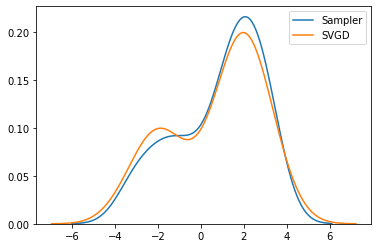

Iteration 2500, 50.0% finished


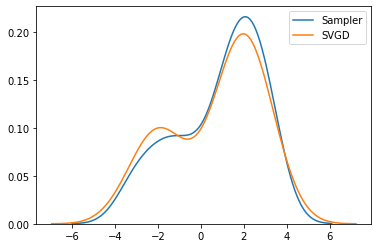

Iteration 3000, 60.0% finished


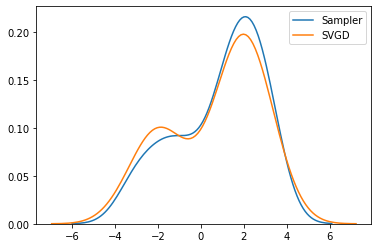

Iteration 3500, 70.0% finished


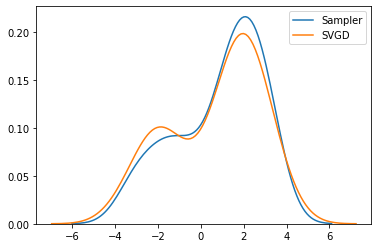

Iteration 4000, 80.0% finished


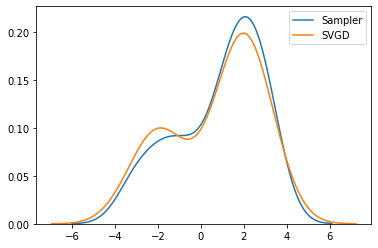

Iteration 4500, 90.0% finished


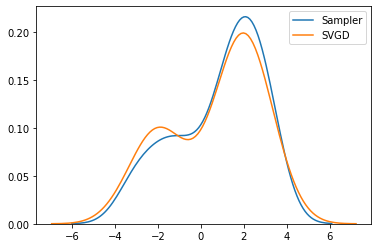

In [6]:
# We then perform the SVGD iterations
def get_plotfunc(true_samples):
    def plotfunc(l, particles):
        fig, ax = plt.subplots(1,1)

        kde1 = sns.kdeplot(true_samples.flatten(), ax=ax, label='Sampler')
        kde2 = sns.kdeplot(particles.flatten(), ax=ax, label='SVGD')

        ax.legend()

        plt.show()
        plt.close()

    return plotfunc


num_iterations = 5000


toy_init_particles = sample_gmm(num_samples,
                                    [1.],
                                    [np.array([-10])],
                                    [np.eye(1)])



plotfunc = get_plotfunc(true_samples)

toy_score = gmm_gld(weights, mus, sigmas)

svgd = SVGD(gld=toy_score)

svgd_samples = svgd.do_svgd_iterations_optimized(init_particles=toy_init_particles,
                                         num_iterations=num_iterations,
                                                  learning_rate=1e-2,
                                                  plotfunc=plotfunc,
                                         progress_freq=10)





In [7]:
%%time

# We also time the 5000 SVGD iterations

svgd_samples = svgd.do_svgd_iterations_optimized(init_particles=toy_init_particles,
                                         num_iterations=num_iterations,
                                                  learning_rate=1e-2,
                                                 progress_freq=1)



Iteration 0, 0.0% finished
CPU times: user 5.01 s, sys: 565 ms, total: 5.58 s
Wall time: 4.95 s


As we can see from the plots above, we achieve a reasonably good approximation to the target KDE within 2000 iterations, and the good approximation remains stable even when we run more iterations than strictly necessary. The second property is desirable because we may not know in advance how many iterations we want to run. The good approximation remaining stable means that we can err on the side of caution and run more iterations than we think is strictly necessary without having to worry that the algorithm will start to diverge.

The above example illustrates how the SVGD algorithm produces good results even when the initial guess is far from the truth. We note also that in this case, the algorithm successfully captured both modes, though fails to do so when the modes are farther apart. See the [failure modes](#Mode-seeking-(KL-divergence)) section for more details.

We compare the results above with Hamiltonian Monte Carlo (HMC).

At iteration 0
At iteration 100
At iteration 200
At iteration 300
At iteration 400
The acceptance rate is 1.000
HMC Sampler took 82.50624489784241 seconds.


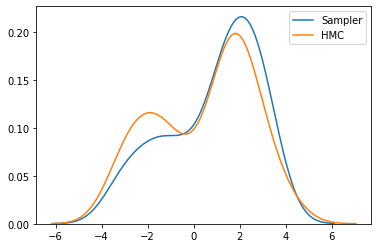

In [8]:
def get_plotfunc(true_samples):
    def plotfunc(particles):
        fig, ax = plt.subplots(1,1)

        kde1 = sns.kdeplot(true_samples.flatten(), ax=ax, label='Sampler')
        kde2 = sns.kdeplot(particles.flatten(), ax=ax, label='HMC')

        ax.legend()

        plt.show()
        plt.close()

    return plotfunc

plotfunc = get_plotfunc(true_samples)

log_pdf = log_gmm_pdf_vectorized(weights, mus, sigmas)

target_energy = lambda x: -log_pdf(x)

gld = gmm_gld(weights, mus, sigmas)

target_grad = lambda x: -gld(x)

#define other parameters
params = {'u_energy': target_energy,
    'u_grad': target_grad,
    'step_size':1.5e-1, 
    'leapfrog_steps':20, 
    'total_samples':500, 
    'burn_in':.6, 
    'thinning_factor':2,
    'position_init': np.asarray([0.]).reshape(1,-1),
        'm':3}

particles = hmc_sampler(**params)

plotfunc(particles)

For the bimodal 1-dimensional Gaussian Mixture Model (GMM), the HMC sampler was also able to recover both modes with minimal tuning and within a relatively small number of samples. The time taken was slower than our SVGD iterations (~80 seconds vs ~5 seconds), though we note that our HMC implementation is not optimized.

We consider HMC to be more complicated than SVGD and it also requires the density (up to proportionality) in order to perform the MH-style accept-reject mechanism. 

Therefore, given that both approaches produce adequate samples in this case, we prefer to use SVGD because it is simpler. 

### More Complicated Case (2D Gaussian Mixture)

We also demonstrate that our implementation is able to handle a more complicated case (in some circumstances): a 2D Gaussian Mixture where the individual Gaussians have different correlations. Being able to capture a correlation structure is of interest because in variational inference, the approximating distribution often lacks the ability to model correlation in order to make the optimization problem tractable. Our target distribution in these experiments is: 


\begin{equation}
p(x) \sim \frac{1}{2}\mathcal{N}\left(\begin{bmatrix} -4\\0 \end{bmatrix}, \begin{bmatrix} 1,-0.33\\ -0.33,1 \end{bmatrix}\right) + \frac{1}{2}\mathcal{N}\left(\begin{bmatrix} 4\\0 \end{bmatrix}, \begin{bmatrix} 1,0.66\\ 0.66,1 \end{bmatrix}\right)
\end{equation}



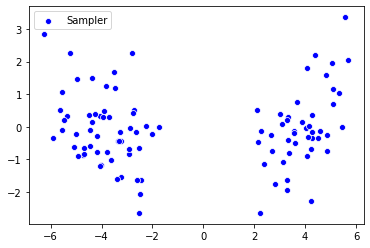

In [9]:
# We first plot the ground truth samples

def get_plotfunc(true_samples):
    def plotfunc(l, particles):
        fig, ax = plt.subplots(1,1)

        sns.scatterplot(x=true_samples[:, 0].flatten(),
                           y=true_samples[:, 1].flatten(),
                           ax=ax,
                        color='blue',
                           label='Sampler')

        sns.scatterplot(x=particles[:, 0].flatten(),
                           y=particles[:, 1].flatten(),
                           ax=ax,
                        color='orange',
                           label='SVGD')


        ax.legend()

        plt.show()
        plt.close()

    return plotfunc


def metrics(log_lik_func):
    def report_metrics(particles):
        df = pd.DataFrame(particles)
        corr = df.corr().iloc[0, 1]
        print("Log Likelihood: {} | Corr: {}".format(log_lik_func(particles), corr))

    return report_metrics



num_iterations = 10000
num_samples = 100

weights = [0.5, 0.5]
mus = [np.array([-4, 0]),
       np.array([4, 0])]
corr1 = -0.33
corr2 = 0.66
sigmas = [np.array([
    [1, corr1],
    [corr1, 1]]),
    np.array([
    [1, corr2],
    [corr2, 1]
    ])]



true_samples = sample_gmm(num_samples, weights, mus, sigmas)

fig, ax = plt.subplots(1,1)

sns.scatterplot(x=true_samples[:, 0].flatten(),
                   y=true_samples[:, 1].flatten(),
                   ax=ax,
                color='blue',
                   label='Sampler')


ax.legend()

plt.show()
plt.close()


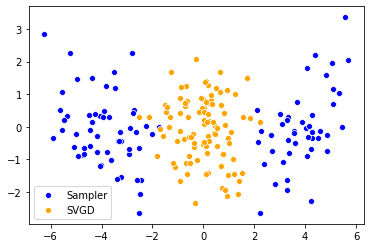

Iteration 0, 0.0% finished


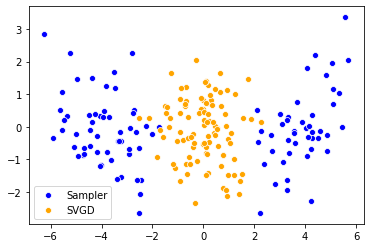

Iteration 2000, 20.0% finished


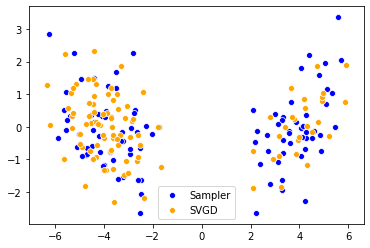

Iteration 4000, 40.0% finished


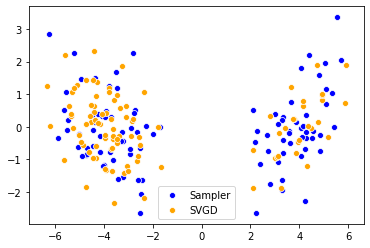

Iteration 6000, 60.0% finished


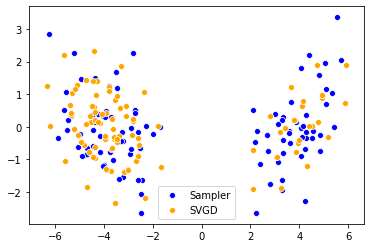

Iteration 8000, 80.0% finished


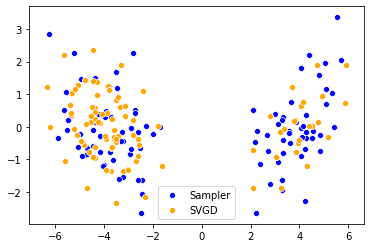

In [10]:
# We then perform the SVGD iterations from a cherry-picked optimal starting location

init_particles = sample_gmm(num_samples,
                                [1.],
                                [np.array([0, 0])],
                                [np.eye(2)])

plotfunc = get_plotfunc(true_samples)

gld = gmm_gld(weights, mus, sigmas)

svgd = SVGD(gld=gld)

log_lik_func = log_lik_gmm(weights, mus, sigmas)

report_metrics = metrics(log_lik_func)

particles = svgd.do_svgd_iterations_optimized(
    init_particles=init_particles,
    num_iterations=num_iterations,
    learning_rate=1e-2,
    plotfunc=plotfunc,
    metrics=None,
    progress_freq=5)



We observe that SVGD yielded a final set of particles that appear to approximate the mixture well after only 2000 iterations, though it appears that the samples that went to the left mode are exhibitng structure and do not appear to be independently distributed (note the inner and outer oval patterns).

In [11]:
%%time

# We also time the 10000 SVGD iterations

svgd_samples = svgd.do_svgd_iterations_optimized(init_particles=init_particles,
                                         num_iterations=num_iterations,
                                                  learning_rate=1e-2,
                                                 progress_freq=1)

Iteration 0, 0.0% finished
CPU times: user 16.7 s, sys: 1.07 s, total: 17.8 s
Wall time: 16.4 s


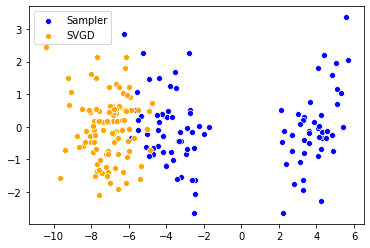

Iteration 0, 0.0% finished


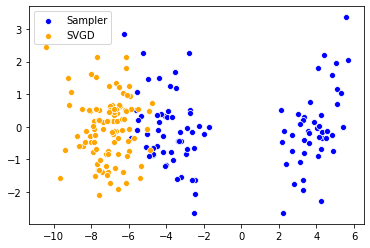

Log Likelihood: -900.4322509765625 | Corr: -0.025831626163685617
Iteration 2000, 20.0% finished


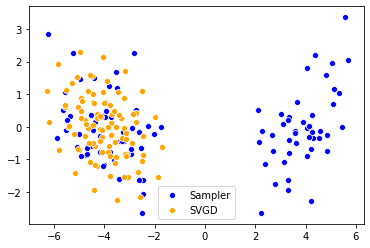

Log Likelihood: -340.1065979003906 | Corr: -0.3218054018806235
Iteration 4000, 40.0% finished


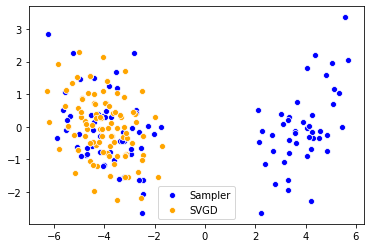

Log Likelihood: -340.3624267578125 | Corr: -0.31965639281342995
Iteration 6000, 60.0% finished


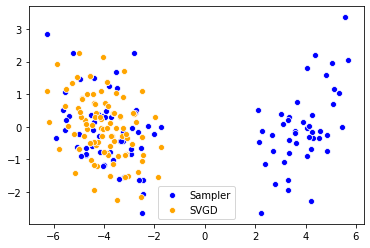

Log Likelihood: -339.1776123046875 | Corr: -0.3313444864877833
Iteration 8000, 80.0% finished


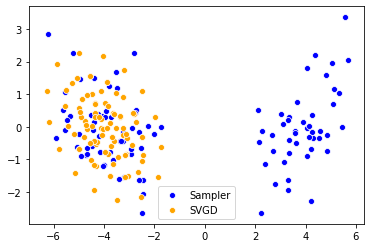

Log Likelihood: -339.04229736328125 | Corr: -0.3329101406547911


In [12]:
# We perform the above experiment again except we start the particles from the left 
# Unfortunately, the particles fail to reach the other mode.

init_particles = sample_gmm(num_samples,
                                [1.],
                                [np.array([-7, 0])],
                                [np.eye(2)])

plotfunc = get_plotfunc(true_samples)

gld = gmm_gld(weights, mus, sigmas)

svgd = SVGD(gld=gld)

log_lik_func = log_lik_gmm(weights, mus, sigmas)

report_metrics = metrics(log_lik_func)

particles = svgd.do_svgd_iterations_optimized(
    init_particles=init_particles,
    num_iterations=num_iterations,
    learning_rate=1e-2,
    plotfunc=plotfunc,
    metrics=report_metrics,
    progress_freq=5)



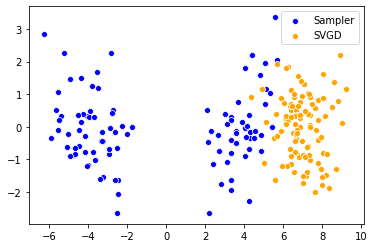

Iteration 0, 0.0% finished


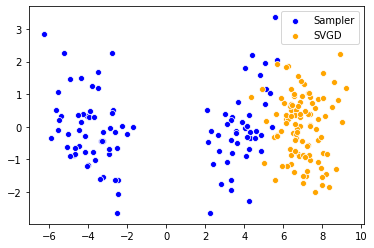

Log Likelihood: -1160.708740234375 | Corr: -0.06843480734456381
Iteration 2000, 20.0% finished


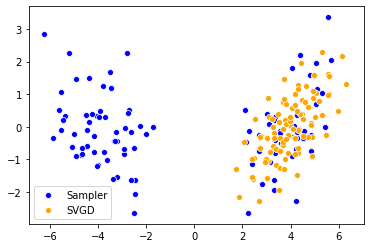

Log Likelihood: -317.0525207519531 | Corr: 0.6595453936623991
Iteration 4000, 40.0% finished


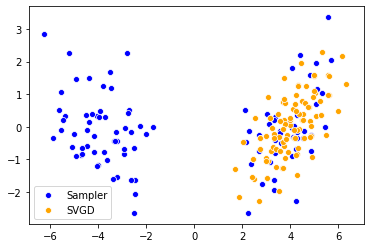

Log Likelihood: -317.8871765136719 | Corr: 0.6548179811023813
Iteration 6000, 60.0% finished


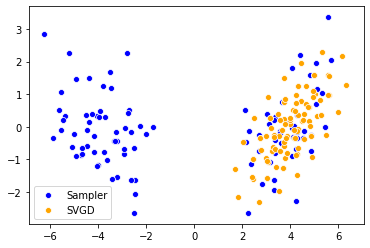

Log Likelihood: -318.27166748046875 | Corr: 0.6525714807907639
Iteration 8000, 80.0% finished


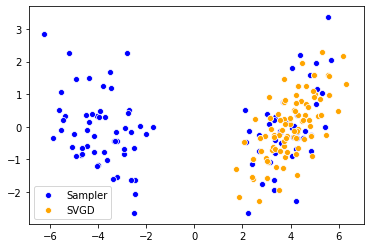

Log Likelihood: -317.0267639160156 | Corr: 0.660188024657872


In [13]:
# We perform the above experiment again except we start the particles from the right.
# Unfortunately, the particles fail to reach the other mode.

init_particles = sample_gmm(num_samples,
                                [1.],
                                [np.array([7, 0])],
                                [np.eye(2)])

plotfunc = get_plotfunc(true_samples)

gld = gmm_gld(weights, mus, sigmas)

svgd = SVGD(gld=gld)

log_lik_func = log_lik_gmm(weights, mus, sigmas)

report_metrics = metrics(log_lik_func)

particles = svgd.do_svgd_iterations_optimized(
    init_particles=init_particles,
    num_iterations=num_iterations,
    learning_rate=1e-2,
    plotfunc=plotfunc,
    metrics=report_metrics,
    progress_freq=5)

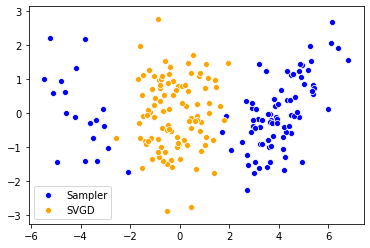

Iteration 0, 0.0% finished


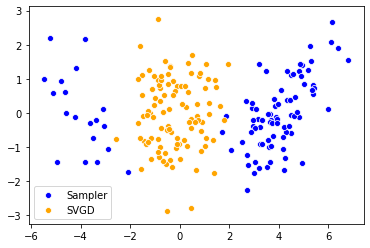

Iteration 2000, 20.0% finished


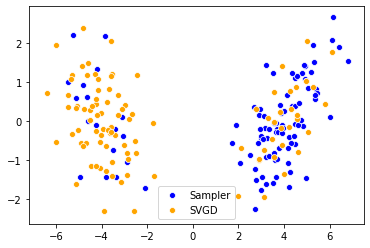

Iteration 4000, 40.0% finished


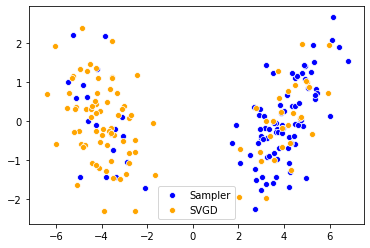

Iteration 6000, 60.0% finished


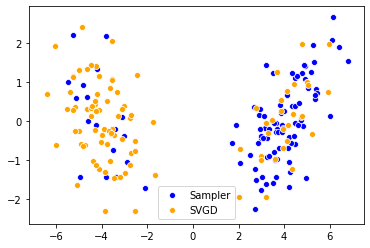

Iteration 8000, 80.0% finished


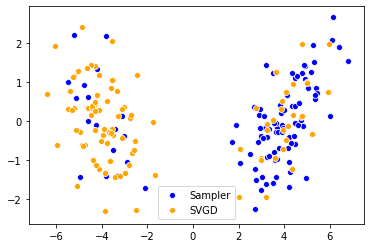

In [14]:
# Finally, we highlight another deficiency: if the mixture weights are unequal, the SVGD particles 
# do not gravitate to the modes in a manner that matches the weights

num_iterations = 10000
num_samples = 100

weights = [1./5, 4./5]
mus = [np.array([-4, 0]),
       np.array([4, 0])]
corr1 = -0.33
corr2 = 0.66
sigmas = [np.array([
    [1, corr1],
    [corr1, 1]]),
    np.array([
    [1, corr2],
    [corr2, 1]
    ])]

init_particles = sample_gmm(num_samples,
                                [1.],
                                [np.array([0, 0])],
                                [np.eye(2)])


true_samples = sample_gmm(num_samples, weights, mus, sigmas)

plotfunc = get_plotfunc(true_samples)

gld = gmm_gld(weights, mus, sigmas)

svgd = SVGD(gld=gld)

log_lik_func = log_lik_gmm(weights, mus, sigmas)

report_metrics = metrics(log_lik_func)

particles = svgd.do_svgd_iterations_optimized(
    init_particles=init_particles,
    num_iterations=num_iterations,
    learning_rate=1e-2,
    plotfunc=plotfunc,
    metrics=None,
    progress_freq=5)




We conclude that, while sampling via SVGD is able to capture correlation, the choice of initial particles actually does matter if one hopes to achieve sufficient mode coverage. See the [failure modes](#Mode-seeking-(KL-divergence)) section for more examples. 

We also attempt to obtain samples from the above using HMC.

At iteration 0
At iteration 100
At iteration 200
At iteration 300
At iteration 400
The acceptance rate is 0.866
HMC Sampler took 91.7010350227356 seconds.


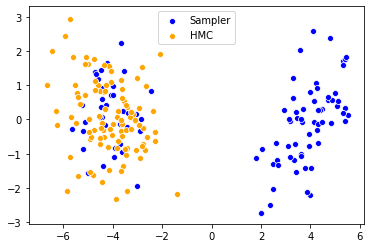

In [15]:
def get_plotfunc(true_samples):
    def plotfunc(l, particles):
        fig, ax = plt.subplots(1,1)

        sns.scatterplot(x=true_samples[:, 0].flatten(),
                           y=true_samples[:, 1].flatten(),
                           ax=ax,
                        color='blue',
                           label='Sampler')

        sns.scatterplot(x=particles[:, 0].flatten(),
                           y=particles[:, 1].flatten(),
                           ax=ax,
                        color='orange',
                           label='HMC')


        ax.legend()

        plt.show()
        plt.close()

    return plotfunc


num_iterations = 10000
num_samples = 100

weights = [0.5, 0.5]
mus = [np.array([-4, 0]),
       np.array([4, 0])]
corr1 = -0.33
corr2 = 0.66
sigmas = [np.array([
    [1, corr1],
    [corr1, 1]]),
    np.array([
    [1, corr2],
    [corr2, 1]
    ])]

true_samples = sample_gmm(num_samples, weights, mus, sigmas)

plotfunc = get_plotfunc(true_samples)

log_pdf = log_gmm_pdf_vectorized(weights, mus, sigmas)

target_energy = lambda x: -log_pdf(x)

gld = gmm_gld(weights, mus, sigmas)

target_grad = lambda x: -gld(x)

#define other parameters
params = {'u_energy': target_energy,
    'u_grad': target_grad,
    'step_size':1., 
    'leapfrog_steps':15, 
    'total_samples':500, 
    'burn_in':.6, 
    'thinning_factor':2,
    'position_init': np.asarray([0., 0.]).reshape(1,-1),
        'm':1}

particles = hmc_sampler(**params)

plotfunc(1, particles)

For the 2-Dimensional GMM, the HMC sampler was unable to recover both modes even after significant parameter tuning in terms of the step size, the variance of the proposal momentum distribution, and the number of steps for the leapfrog integrator. SVGD also finished faster in this case as well.

This highlights that sampling from multi-modal distributions remains difficult and largely artisanal even with a properly implemented HMC sampler.

Practically speaking, because we used knowledge of the locations of the modes to achieve convergence to both modes via SVGD, we consider the performance of both samplers to be roughly the same. We still prefer SVGD because it is less complicated than HMC.


### Failure Modes

#### Mode seeking (KL divergence)

In our experiments, we noticed that, despite the author's example that SVGD was able to capture the second mode in the 1D Gaussian Mixture, the SVGD particles can actually get stuck at a mode. This is unsurprising because of the mode seeking behavior of the optimization problem KL(Q||P), which SVGD is minimizing behind the scenes. We consider this a failure mode because, under a poor initialization, SVGD will not produce particles that are representative of the distribution in its entirety.

Below are two plots of the KDE of the SVGD particles at iterations 0 and 4500 for when the modes are -4 and 4, and the weighitng is equal. 

<img src="./figs/1d_multimodal_medium_equal/0.png" style="width:300px;height:200px;">
<img src="./figs/1d_multimodal_medium_equal/4500.png" style="width:300px;height:200px;">

This behavior also occurs in the 2D setting. Below are three scatterplots at iterations 0, 1000, and 9900 for SVGD iterations attempting to sample from a bimodal bivariate GMM where each Gaussian has no correlation. We observe that the particles gravitate towards the left mode and remain there:

<img src="./figs/bimodal_bivariate_gmm_medium_equal_uncorrelated/0.png" style="width:300px;height:200px;">
<img src="./figs/bimodal_bivariate_gmm_medium_equal_uncorrelated/1000.png" style="width:300px;height:200px;">
<img src="./figs/bimodal_bivariate_gmm_medium_equal_uncorrelated/9900.png" style="width:300px;height:200px;">


A better initialization of the particles can address this problem in some cases. For example, consider a uniform initialization of particles in a 1D Gaussian Mixture where the modes are far apart (-8, 8). Then the KDE estimates at iterations 0 and 450 are:

<img src="./figs/1d_multimodal_far_equal_uniform/0.png" style="width:300px;height:200px;">
<img src="./figs/1d_multimodal_far_equal_uniform/450.png" style="width:300px;height:200px;">

Both modes were successfully captured under this initialization.

Unfortunately, if the modes have unequal weighting, the correct proportion of particles will not go to each mode:


<img src="./figs/1d_multimodal_far_unequal_uniform/0.png" style="width:300px;height:200px;">
<img src="./figs/1d_multimodal_far_unequal_uniform/450.png" style="width:300px;height:200px;">


     


#### Too many particles


Another failure mode of SVGD is when there are too many particles in suboptimal implementations. Though our implementation is efficient and uses vectorized NumPy operations where possible, it struggled to run when working with a number of particles on the order of 10\*\*4. Below are the times it took to run 100 iterations of SVGD given an initial set of particles of a size in increasing powers of 10. 

     1: 2.212s
     10: 2.373s
     100: 2.522s
     1000: 13.236s
     10000: Did not finish after 24 minutes.

This is not surprising. Computing the full matrix of partial derivatives of K for all particles at each iterations has complexity $O(n^2)$ and so a computation on the order of $10^8$ at least is performed at each iteration, which can be slow.

The authors recommend approximating the two terms with mini batches to improve performance.


#### Suboptimal RBF parameter

If the RBF parameter is chosen poorly, the SVGD points can cluster too closely:

<img src="./figs/bad_rbf/4900.png" style="width:300px;height:200px;">

The above scenario corresponds to when h is too small, causing the kernel values to decay too quickly thus causing the particle repulsion to be deficient. 


#### Insufficient # of iterations

Unsurprisingly, if the number of iterations is not sufficient, the particles will not converge.

<img src="./figs/too_few_iters/98.png" style="width:300px;height:200px;">

Fortunately, making the number of iterations more than necessary does not cause problems and because the iterations are gradient descent like, they can be augmented with momentum, adagrad, adam, etc. to improve performance.

#### Suboptimal learning rate

Also unsurprisingly, if the learning rate is too low, the particles will fail to move to regions of high density for p and if the learning rate is too high, the SVGD iterations will diverge.

Learning rate too low, 9800 iterations:
<img src="./figs/lr_too_low/9800.png" style="width:300px;height:200px;">

Learning rate too high, iniital configuration and first update:
<img src="./figs/lr_too_high/0.png" style="width:300px;height:200px;">
<img src="./figs/lr_too_high/1.png" style="width:300px;height:200px;">




#### Numerical Instability under high correlation

In our experiments with high correlation ($\rho$ >= 0.9), we observed some numerical instability when initializing the particles away from the centers of highest density. That is, the particles would tend to diverge. If $\rho$ was too high (.95), the particles would not converge at all from any starting location.


## Evaluation



Our overall impressions of the SVGD algorithm are favorable because, while the approach appears not to solve the problem of mode coverage, a major problem in variational inference, it is able to capture the correlation in the modes that it does visit and is relatively easy to understand and implement compared with other sampling techniques that work well for complicated distributions. 

Therefore, we feel that the authors have put forth a credible alternative for performing variational inference that, as least in some common situations, outperforms or matches other available methods, while yielding some simplification in terms of the artisanal work needed for VI or sampling.

However, the proposed method is still unable to overcome traditional VI short-comings, such as mode-seeking behavior leading to an incomplete exploration of the sampling space, and the difficulty of Bayesian methods in general, such as the sensitivity of sampling and VI methods to the initialization points. We have also demonstrated that tuning the learning rate and other parameters is non-trivial and can have a significant performance impact.

One drawback of SVGD is that a naive implementation does not scale to settings where one would want tens of thousands of particles. One can parallelize the computations of the gradient or use mini-batches to approximate the gradient to speed things up. One can also use mini batches for the term containing the gradient of the kernel as well.

Though we do not have sufficient background to rigorously assess the mathematics used in the derivation of the algorithm, the paper appeared to be technically sound and we were not able to find anything obviously wrong in the key steps of derivation. 

Based on our and the authors' experiments, the proposed algorithm is practical to use on real data and tasks because 

1. it is more straightforward to use than many existing sampling techniques and variational inference techniques
2. it does not require specifying a variational family
3. it appears to not perform worse than existing techniques when used for sampling in Bayesian models for classification and regression tasks or sampling in general. While it does not easily obtain full mode coverage, most techniques do not and so this technique is simultaneously no worse than other techniques while also being easier to use.
4. it is reasonably fast when obtaining a number samples under the order of $10^3$ 
5. it is a black box technique that requires only the gradient of the logarithm of the density (GLD) of a distribution which can be computed via automatic differentiation
6. it can be modified via the typical gradient / stochastic gradient descent techniques to achieve better converge properties and scalability.


Though the experimental section gave a false impression of robustness in the toy example, the performance of the Bayesian Logistic Regression (BLR) and Bayesian Neural Network (BNN) compared with other techniques suggest that SVGD is competitive with existing approaches for serious classification and regression tasks. Though a comparison with a naive baseline would've helped the author's case for the reported metrics from the BLR and BNN, it is unlikely that the competitive performance of the BLR and BNN using posterior samples obtained via SVGD were due to random chance.


Most importantly, we believe that the authors have achieved their goal of making a variational inference algorithm that requires less specialized knowledge. Though artisanal tuning may achieve better performance in some cases, SVGD appears to work well in a broad enough number of tasks to be of practical significance for other researchers and engineers.
     

## Future work

We propose some directions for further analysis. 

From a mathematical perspective, it would be interesting to assess the efficiency of the "functional gradient descent" steps derived by the authors. That is, what is lost by restricting the search space of the steps to a reproducing kernel hilbert space? Furthermore, it would be useful and interesting to rigorously verify the convexity of the functional optimization objective KL(q||p). Finally, it would be worthwhile to reference the relevant functional analysis and optimization literature to determine whether there are closed forms solutions to the functional optimization problem where  $\mathcal{F}$ is a broader set of functions.

We would also like to perform an analysis of how different choices of the kernel affect the particle movement in the SVGD iterations. This line of inquiry was lacking in the original paper and it's possible that changing the kernel might have an appreciable impact on the performance of the algorithm.

Stein's Identity holds for weakly differentiable functions i.e. the ReLu activation. Based on this, it would be of interest to see how poorly SVGD performs when the posterior is not a smooth function. Perhaps using Matern kernel variants would yield better performane in this case.

A current shortcoming of SVGD is the mode seeking behavior, and the fact that, even with a broad set of starting points, SVGD cannot adequately assign samples to modes that captures the mode's relative weight. It would therefore be useful to extend SVGD to account for these shortcomings. For example, perhaps some initial "particle explosion" can spread the initial particles out over $\mathbb{R}^n$ so that they visit more modes.

One of the author's goals was to reduce the design choices necessary in variational inference. One could make SVGD even simpler by removing the choice of kernel. To this end, is it possible to use a nonparametric kernel that only depends on the particles?

Given that the authors use momentum and adagrad in their implementation, it might be worth assessing the impact of other SGD modifications such as adam on SVGD.

Shi et al. have recently (2018) proposed [Spectral Stein Gradient Estimator](https://arxiv.org/abs/1806.02925) which estimates the gradient log density of an arbitrary distribution given samples. Their approach is appealing because it extends to an out of sample setting. That in tandem with SVGD would give a procedure for generating more samples from a given set of samples from any distribution in a largely black box manner (i.e. samples -> GLD -> SVGD -> more samples). It would be interesting to explore how well combining the two approaches works ("Spectral Stein Variational Sample Extensions"). 

One difficulty with SVGD and samplers in general is assessing its performance in a high dimensional setting. We used visual checks because we tested it only the 1D and 2D settings. In higher dimensions, we face the general challenge of determining whether the samples produced from the SVGD procedure approximate the target distribution well. Therefore, to more rigorously assess the performance of SVGD, we propose exploring the literature for current techniques in high dimensional hypothesis tests for either two samples or for one sample and a given density. An example of such a test is [A Kernel Two-Sample Test](http://www.jmlr.org/papers/volume13/gretton12a/gretton12a.pdf). There are many others.

In general, we are also interested in optimizing our implementation for numerical stability and efficiency. To this end, we would be interested in parallelizing our code as much as possible and reducing repeated computations where possible. We would also like to explore how to make SVGD scale to work in a high dimensional, high sample setting.